<a href="https://colab.research.google.com/github/vahidseydi/CGN/blob/main/GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

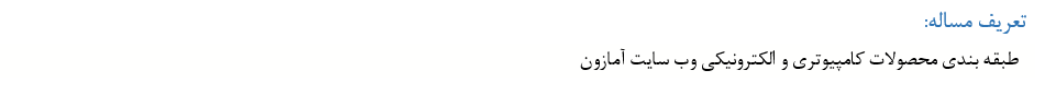

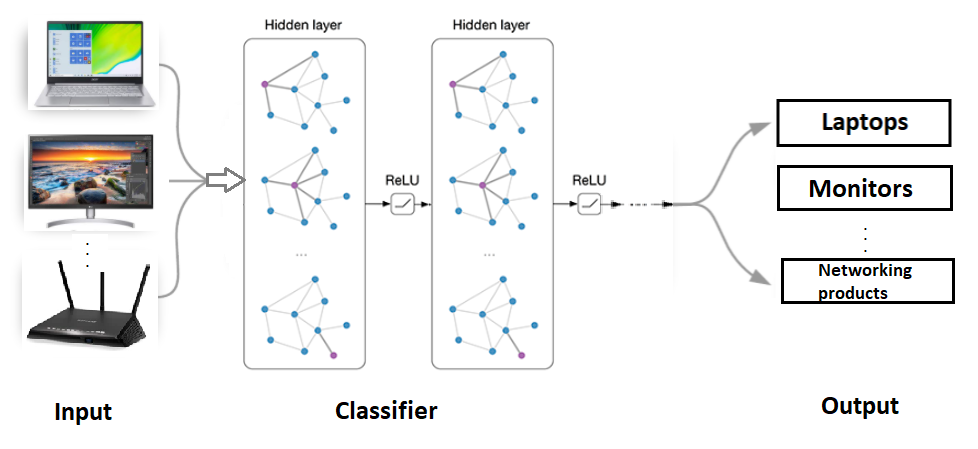

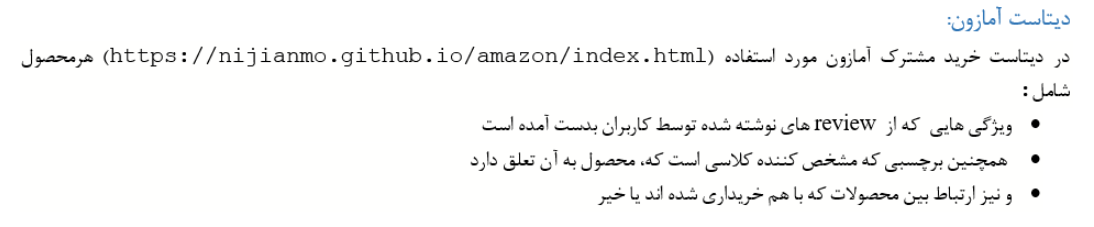

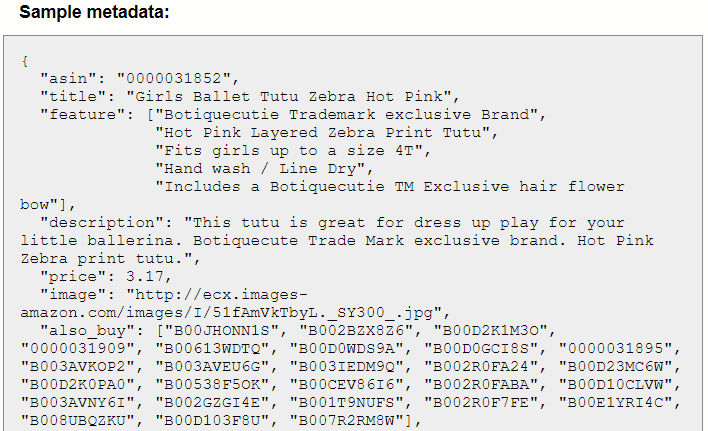

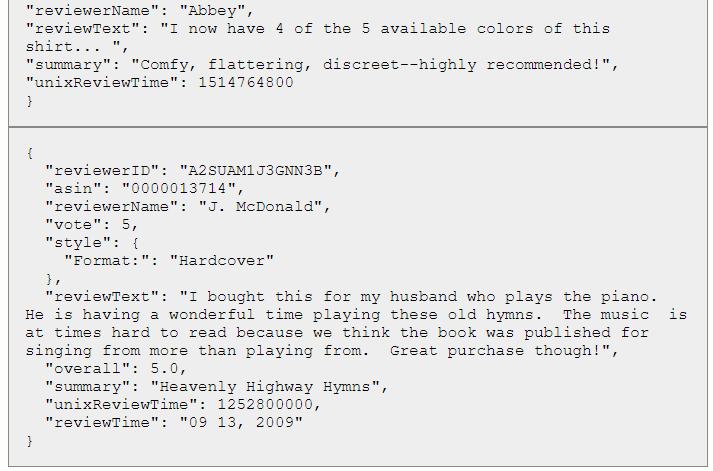

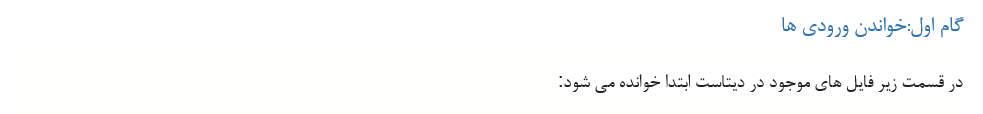

In [ ]:
import numpy as np
npz_data=np.load('/content/drive/MyDrive/Datasets/amazon_electronics_computers (1).npz')
npz_data.files


['adj_data',
 'adj_indices',
 'adj_indptr',
 'adj_shape',
 'attr_data',
 'attr_indices',
 'attr_indptr',
 'attr_shape',
 'labels',
 'class_names']

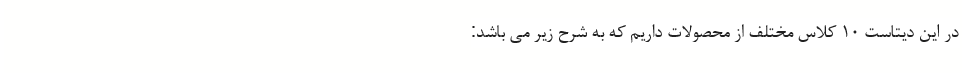

In [ ]:
class_names =npz_data['class_names']
class_names

array(['Desktops', 'Data Storage', 'Laptops', 'Monitors',
       'Computer Components', 'Video Projectors', 'Routers', 'Tablets',
       'Networking Products', 'Webcams'], dtype='<U19')

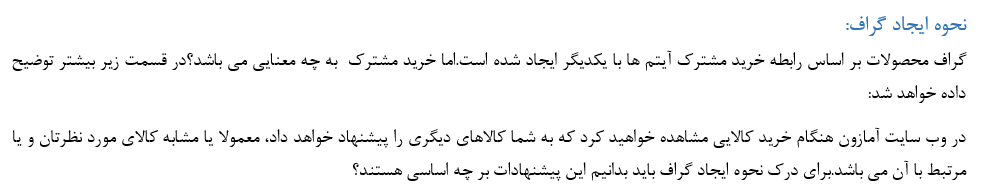

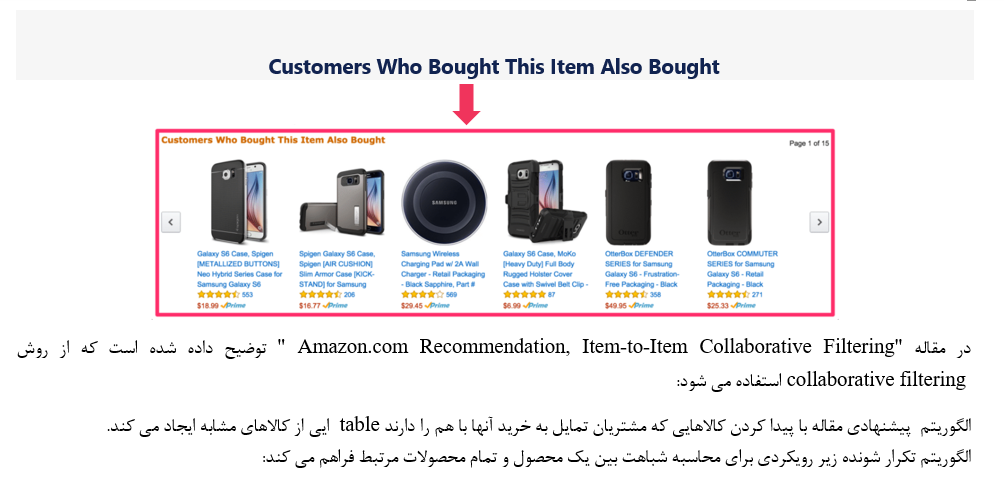

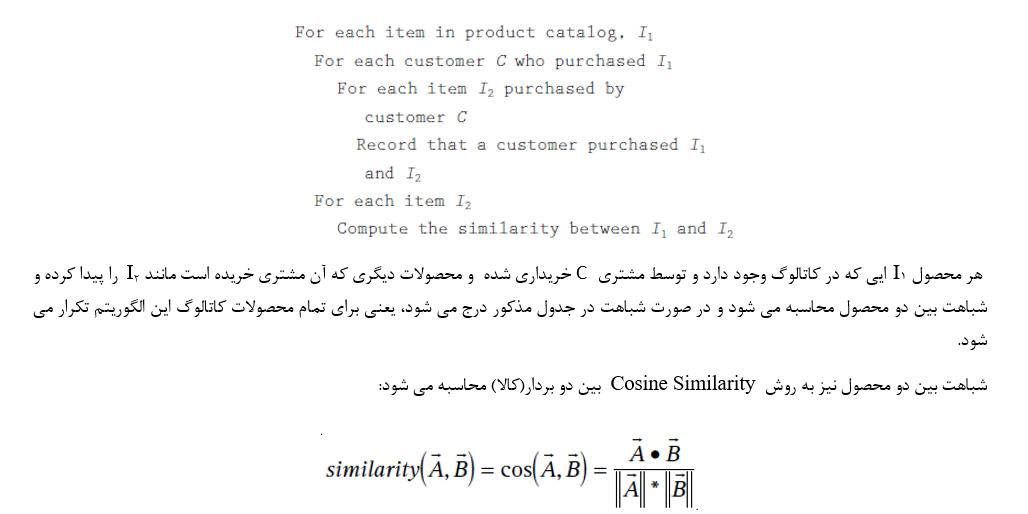

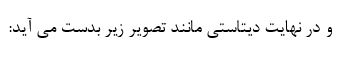

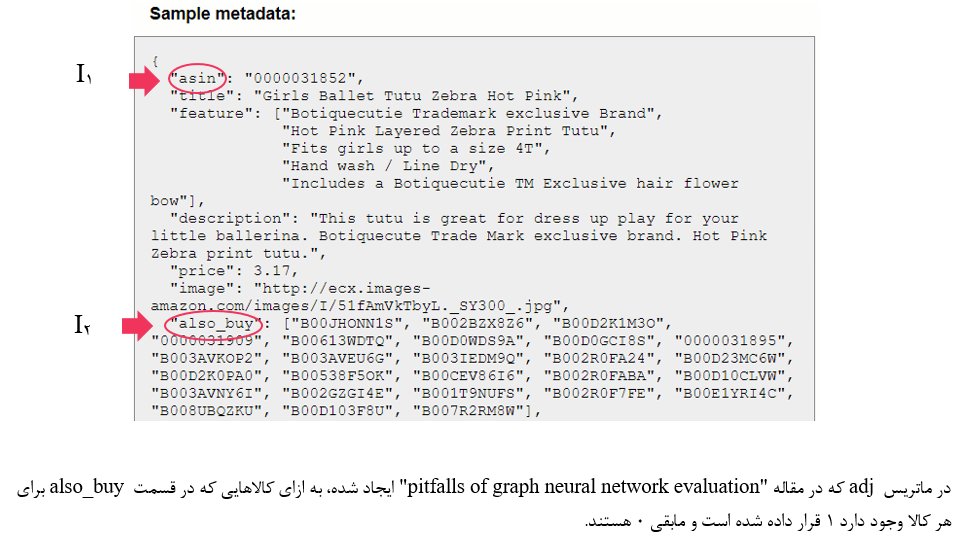

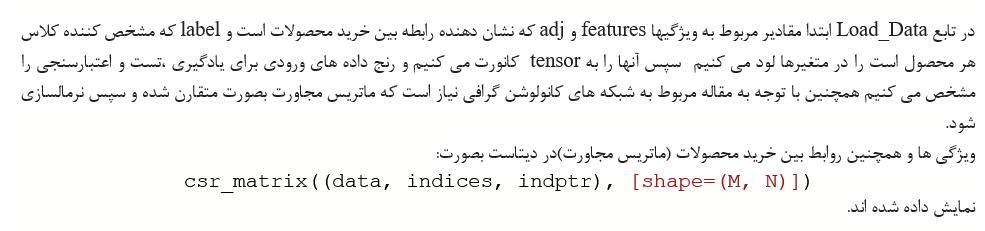

In [ ]:
import numpy as np
import scipy.sparse as sp
import torch
from scipy.sparse import  csr_matrix


def load_data():

 features = sp.csr_matrix((npz_data['attr_data'], npz_data['attr_indices'], npz_data['attr_indptr']),
                                        shape=npz_data['attr_shape'])

 # build graph
 
 adj= sp.csr_matrix(sp.csr_matrix((npz_data['adj_data'], npz_data['adj_indices'], npz_data['adj_indptr']),
                                   shape=npz_data['adj_shape']))
 
 # build symmetric adjacency matrix

 adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
 adj = normalize(adj + sp.eye(adj.shape[0]))
 #اول اعداد 0 و 1 هست بعد از نرمالایز تغییر میکند 

 labels=npz_data['labels']

 idx_train = range(9100)
 idx_val = range(9100,11500)
 idx_test = range(11500, 13381)

 idx_train = torch.LongTensor(idx_train)
 idx_val = torch.LongTensor(idx_val)
 idx_test = torch.LongTensor(idx_test)

 features = torch.FloatTensor(np.array(features.todense()))
 adj = torch.FloatTensor(np.array(adj.todense()))
 labels = torch.LongTensor(labels)


 return adj, features, labels, idx_train, idx_val, idx_test

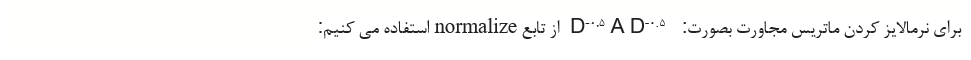

In [ ]:
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    #sum in every row 
    r_inv = np.power(rowsum, -1).flatten()
    # every sum to the power of -1 
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    #diagonal matrice 
    mx = r_mat_inv.dot(mx)
    return mx

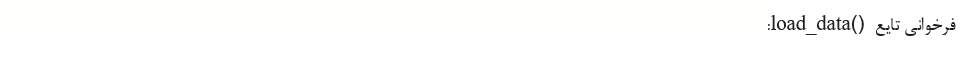

In [ ]:
adj, features, labels, idx_train, idx_val, idx_test = load_data()


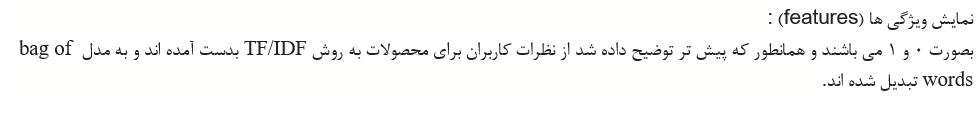

In [ ]:
features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 1., 1., 0.]])

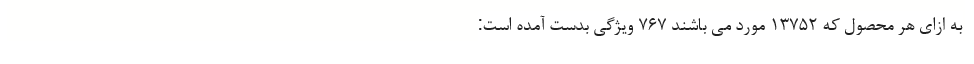

In [ ]:
features.shape

torch.Size([13752, 767])

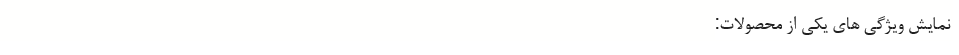

In [ ]:
features[1]
#feature ha 0 , 1 hastan

tensor([1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
        1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
        0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
        1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
        0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 

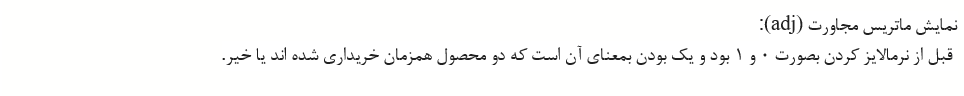

In [ ]:
adj

tensor([[0.2000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0120, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0294,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0333, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0161, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0333]])

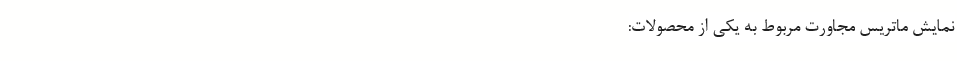

In [ ]:
adj[1]

tensor([0.0000, 0.0120, 0.0000,  ..., 0.0000, 0.0000, 0.0000])

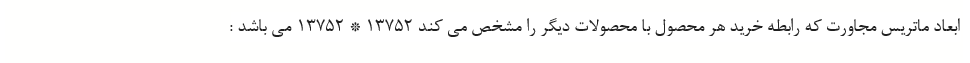

In [ ]:
adj.shape

torch.Size([13752, 13752])

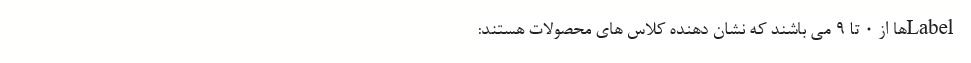

In [ ]:
labels

tensor([4, 4, 8,  ..., 8, 4, 0])

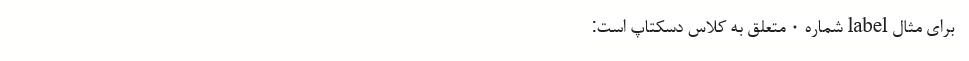

In [ ]:
class_names[0]

'Desktops'

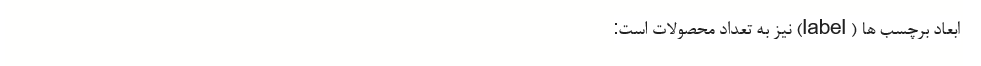

In [ ]:
labels.shape

torch.Size([13752])

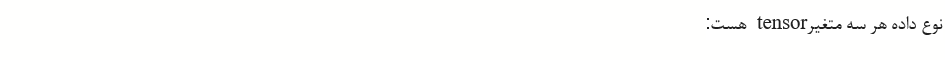

In [ ]:
type(labels)

torch.Tensor

In [ ]:
type(adj)

torch.Tensor

In [ ]:
type(features)

torch.Tensor

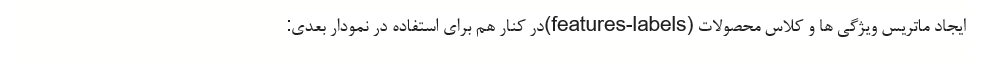

In [ ]:
XZ=np.insert(features,767,labels,axis=1)
XZ.shape
XZ
# inserting labels to the last column of feature
#having each node with its feature and label

tensor([[0., 0., 0.,  ..., 0., 0., 4.],
        [1., 1., 0.,  ..., 1., 0., 4.],
        [0., 0., 0.,  ..., 0., 0., 8.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 8.],
        [1., 0., 0.,  ..., 0., 0., 4.],
        [1., 1., 0.,  ..., 1., 0., 0.]])

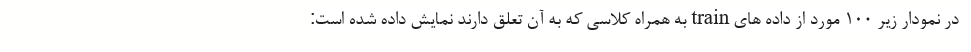

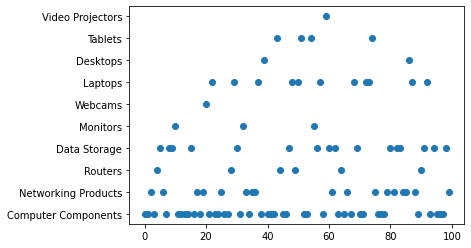

In [ ]:
import matplotlib.pyplot as plt
x=idx_train[:100].tolist()
type(XZ)
y1=[]
i=0
while i < 100:
  y1=np.append(y1,class_names[int(XZ[(i,767)])])
  i=i+1

y1=y1.tolist()
plt.scatter(x, y1)
plt.show()
#plotting first 100 of x_train to show their categories

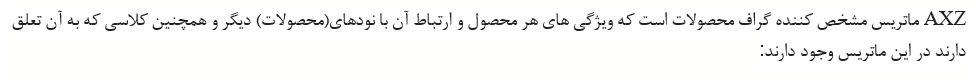

In [ ]:
AXZ=np.insert(XZ,0,adj,axis=1)
AXZ
#inserting adj to the first column of XZ
#having each node with its feature , label and relation with other nodes

tensor([[0.2000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 4.0000],
        [0.0000, 0.0120, 0.0000,  ..., 1.0000, 0.0000, 4.0000],
        [0.0000, 0.0000, 0.0294,  ..., 0.0000, 0.0000, 8.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 8.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 4.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000]])